[I 2024-01-03 17:59:12,971] A new study created in memory with name: no-name-f2fc0fbd-e496-436e-94e2-9a410f580a9d


[I 2024-01-03 17:59:12,974] Trial 0 finished with value: -0.4050852981783859 and parameters: {'alpha': 0.3006689197597475, 'l1_ratio': 0.5733137136484177, 'fit_intercept': True, 'max_iter': 2642}. Best is trial 0 with value: -0.4050852981783859.
[I 2024-01-03 17:59:12,981] Trial 1 finished with value: -0.9217828807383757 and parameters: {'alpha': 0.0089321306950591, 'l1_ratio': 0.4871135027370874, 'fit_intercept': False, 'max_iter': 3257}. Best is trial 0 with value: -0.4050852981783859.
[I 2024-01-03 17:59:12,985] Trial 2 finished with value: -0.36392088617238993 and parameters: {'alpha': 0.18001105881242085, 'l1_ratio': 0.6310830756041865, 'fit_intercept': True, 'max_iter': 683}. Best is trial 2 with value: -0.36392088617238993.
[I 2024-01-03 17:59:12,988] Trial 3 finished with value: -0.634205370991509 and parameters: {'alpha': 0.015288221669530179, 'l1_ratio': 0.7464932937251448, 'fit_intercept': True, 'max_iter': 8282}. Best is trial 2 with value: -0.36392088617238993.
[I 2024-01-

Best Parameters: {'alpha': 0.4999612470854151, 'l1_ratio': 1.7724885768360347e-05, 'fit_intercept': False, 'max_iter': 9541}
Średni błąd kwadratowy (MSE): 176.56372574787548
Procentowa zgodność: -8.60%


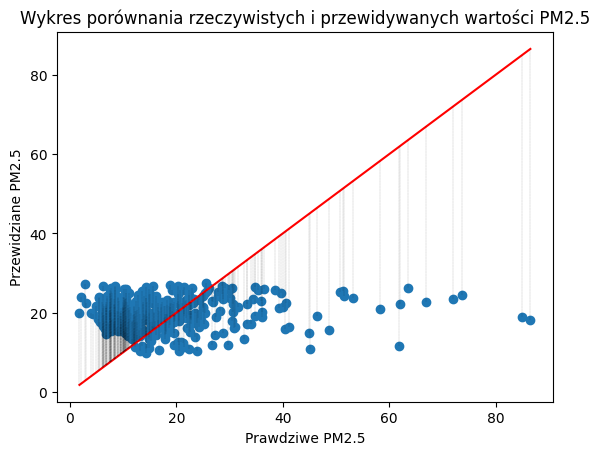

Średni błąd kwadratowy (MSE): 86.79320903887489
r2 score: -158.02%


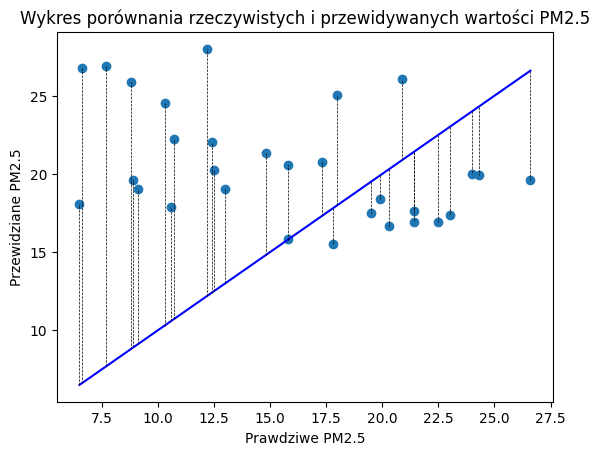

[I 2024-01-03 18:22:02,077] A new study created in memory with name: no-name-e61a9e14-7a37-4a8e-a709-1ed2f8e45829
[I 2024-01-03 18:22:02,095] Trial 0 finished with value: -0.16503041479789848 and parameters: {'alpha': 0.22322273759102307, 'l1_ratio': 0.2107344797955537, 'fit_intercept': False, 'max_iter': 9227}. Best is trial 0 with value: -0.16503041479789848.
[I 2024-01-03 18:22:02,101] Trial 1 finished with value: 0.5423860338426335 and parameters: {'alpha': 0.058754975560719555, 'l1_ratio': 0.6335800008865967, 'fit_intercept': True, 'max_iter': 5241}. Best is trial 1 with value: 0.5423860338426335.
[I 2024-01-03 18:22:02,107] Trial 2 finished with value: -0.23523601997903776 and parameters: {'alpha': 0.3369621692312635, 'l1_ratio': 0.1645521913898469, 'fit_intercept': False, 'max_iter': 6597}. Best is trial 1 with value: 0.5423860338426335.
[I 2024-01-03 18:22:02,114] Trial 3 finished with value: 0.1462814806087387 and parameters: {'alpha': 0.10283863375139914, 'l1_ratio': 0.817952

Best Parameters: {'alpha': 0.1501793216545292, 'l1_ratio': 0.9999899574506519, 'fit_intercept': True, 'max_iter': 4443}
Średni błąd kwadratowy (MSE): 153.10116067789636
Procentowa zgodność: 75.70%


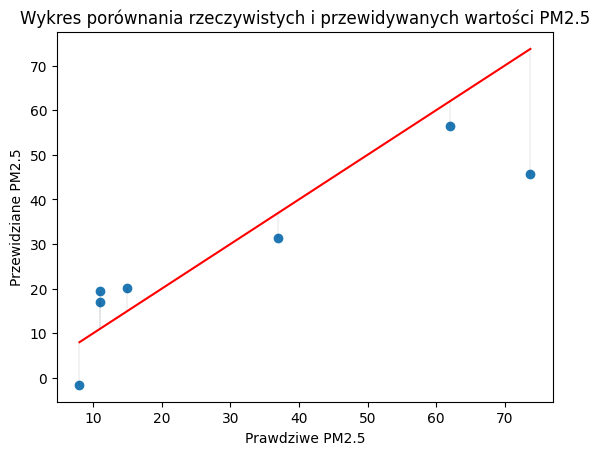

Średni błąd kwadratowy (MSE): 104.88247296872524
r2 score: -211.79%


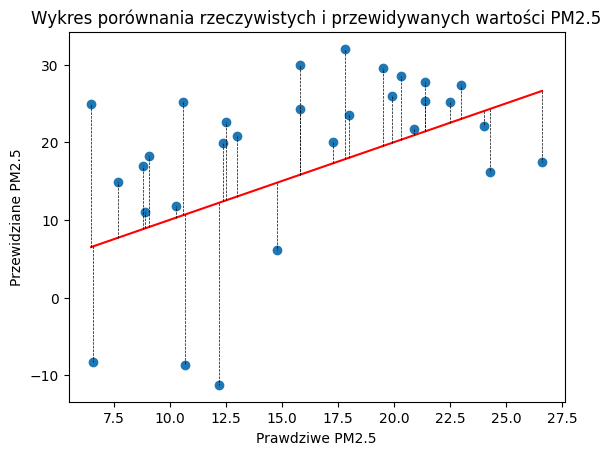

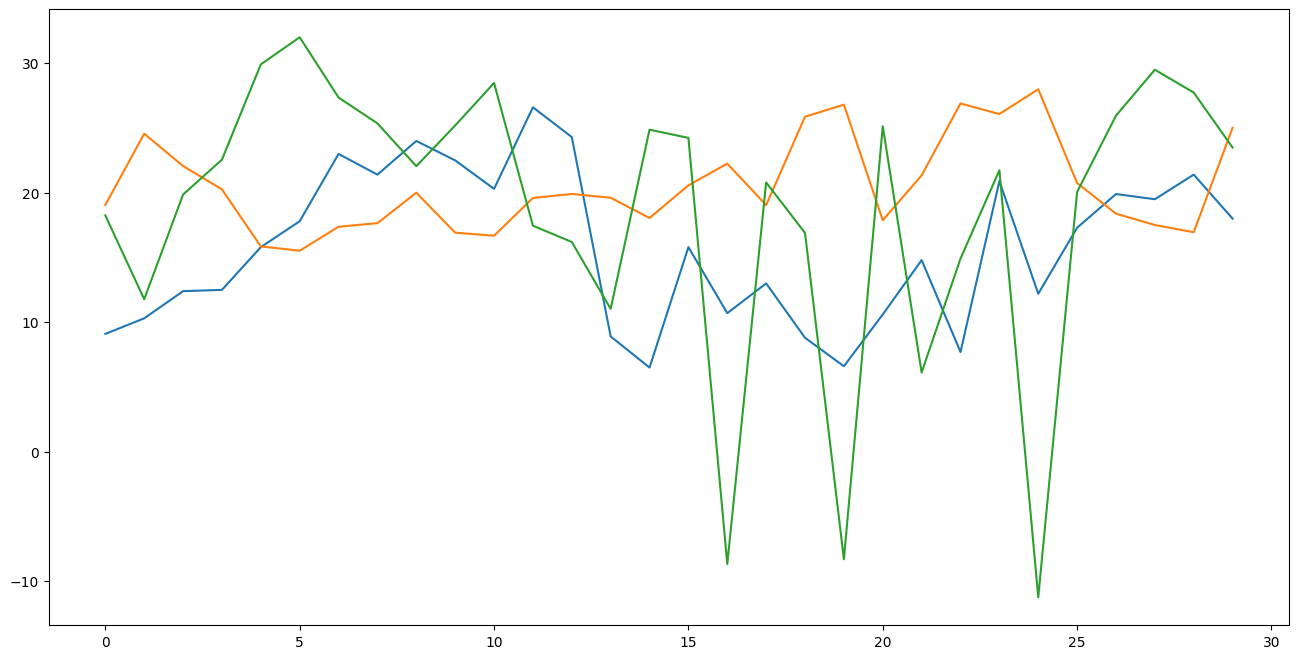

Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): 70.00%


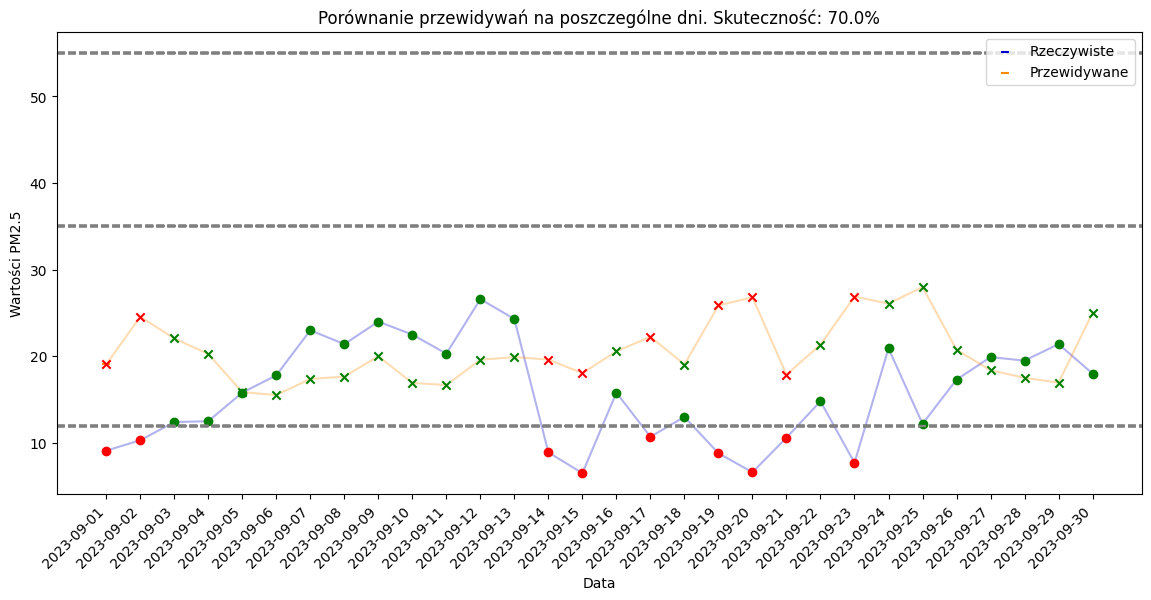

Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): 70.00%


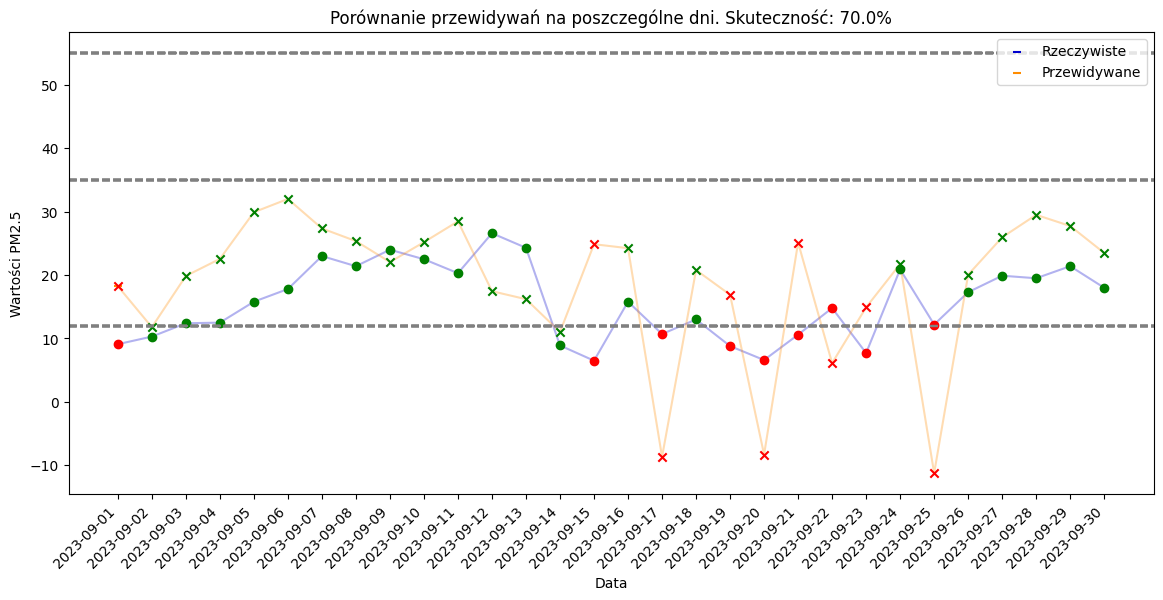

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import optuna
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.patches as mpatches
import seaborn as sns

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 0.5)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 10000)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, max_iter=max_iter, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 1000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Best Parameters:", best_params)

model = ElasticNet(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']
X_test_test_scaled = scaler.transform(X_test_test)

y_pred_test = model.predict(X_test_test_scaled)
mse = mean_squared_error(y_test_test, y_pred_test)
r2 = r2_score(y_test_test, y_pred_test)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)], 'b', label='y=x')
plt.scatter(y_test_test, y_pred_test)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()



model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 0.5)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    max_iter = trial.suggest_int('max_iter', 100, 10000)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, max_iter=max_iter, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 1000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Best Parameters:", best_params)

model = ElasticNet(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']
X_test_test_scaled = scaler.transform(X_test_test)


y_pred_test_2 = model.predict(X_test_test_scaled)
mse = mean_squared_error(y_test_test, y_pred_test_2)
r2 = r2_score(y_test_test, y_pred_test_2)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)],'r', label='y=x')
plt.scatter(y_test_test, y_pred_test_2)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test_2[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()


plt.figure(figsize=[16,8])
plt.plot(y_test_test)
plt.plot(y_pred_test)
plt.plot(y_pred_test_2)
plt.show()
def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 12
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': y_pred_test
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
procent_poprawnych = round(procent_poprawnych, 2)
print(f"Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): {procent_poprawnych:.2f}%")
procent_poprawnych = str(procent_poprawnych)



plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color='mediumblue',marker='_')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color='darkorange',marker='_')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o',zorder=2)
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x',zorder=2)

    progi_jakosci_powietrza = [12, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')

plt.plot(results['Data'], results['Rzeczywiste wartości (y_test)'], color='mediumblue',alpha=0.3, linestyle='-', zorder=1)
plt.plot(results['Data'], results['Przewidywane wartości (y_pred)'], color='darkorange',alpha=0.3, linestyle='-', zorder=1)


plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni. Skuteczność: '+procent_poprawnych+'%')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()



# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': y_pred_test_2
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()

procent_poprawnych = results['Zgadza się'].mean() * 100
procent_poprawnych = round(procent_poprawnych, 2)
print(f"Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): {procent_poprawnych:.2f}%")
procent_poprawnych = str(procent_poprawnych)


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color='mediumblue',marker='_')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color='darkorange',marker='_')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o',zorder=2)
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x',zorder=2)

    progi_jakosci_powietrza = [12, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')

plt.plot(results['Data'], results['Rzeczywiste wartości (y_test)'], color='mediumblue',alpha=0.3, linestyle='-', zorder=1)
plt.plot(results['Data'], results['Przewidywane wartości (y_pred)'], color='darkorange',alpha=0.3, linestyle='-', zorder=1)


plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni. Skuteczność: '+procent_poprawnych+'%')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()